# Political Bias Detection in German News Articles

In [23]:
import random
import tensorflow
from explore_data import*
from prepare_data import*
from classifiers.embedding import*
from classifiers.lstm import*
from classifiers.metrics import*
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration

### GermaParl

In order to explore GermaParl download the dataset from [here](https://github.com/PolMine/GermaParlTEI).

In [2]:
germa_parl = GermaParl('GermaParlTEI')

### News Articles

Either download the the pickle files from [here](https://drive.google.com/file/d/13Kp7rEwMcM-1wb8usEjdnxbLGZPO3y2f/view?usp=sharing) or call ScrapeArchive class for scraping the archive of junge freiheit, jungleworld or sueddeutsche zeitung.

#### Junge Freiheit

In [3]:
jf = Archive('NewsArchive/jungefreiheit_archive.pkl')

#### Jungle World

In [4]:
jw = Archive('NewsArchive/jungleworld_archive.pkl')

#### Sueddeutsche Zeitung

In [5]:
sz = Archive('NewsArchive/sueddeutsche_archive.pkl')

### Bringing everything together, split and preprocessing

In [6]:
combined_data = germa_parl.texts + jw.texts + jf.texts + sz.texts
labels = germa_parl.labels + jw.labels + jf.labels + sz.labels

In [7]:
random.choice(combined_data)

['berlin',
 'dpa',
 'im',
 'weinglas',
 'vor',
 'sigmar',
 'gabriel',
 'wasser',
 'til',
 'schweiger',
 'wirkt',
 'abgekämpft',
 'glamourfaktor',
 'null',
 'beide',
 'schauen',
 'skeptisch',
 'ernste',
 'gesichter',
 'zu',
 'einem',
 'ernsten',
 'thema',
 'steht',
 'auf',
 'der',
 'facebook',
 'seite',
 'des',
 'spd',
 'chefs',
 'zu',
 'einem',
 'foto',
 'geschrieben',
 'das',
 'ihn',
 'in',
 'einem',
 'berliner',
 'club',
 'neben',
 'dem',
 'filmstar',
 'zeigt',
 'direkt',
 'aus',
 'dem',
 'dpa',
 'newskanal',
 'berlin',
 'dpa',
 'im',
 'weinglas',
 'vor',
 'sigmar',
 'gabriel',
 'wasser',
 'til',
 'schweiger',
 'wirkt',
 'abgekämpft',
 'glamourfaktor',
 'null',
 'beide',
 'schauen',
 'skeptisch',
 'ernste',
 'gesichter',
 'zu',
 'einem',
 'ernsten',
 'thema',
 'steht',
 'auf',
 'der',
 'facebook',
 'seite',
 'des',
 'spd',
 'chefs',
 'zu',
 'einem',
 'foto',
 'geschrieben',
 'das',
 'ihn',
 'in',
 'einem',
 'berliner',
 'club',
 'neben',
 'dem',
 'filmstar',
 'zeigt',
 'auf',
 'gabri

Split data into training, validation and test set.

In [8]:
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = train_val_test_split(combined_data, 
                                                                                                 labels, 
                                                                                                 reproduceable=True)

As a preprocessing step we can drop the digits with *drop_digits=True* and all the german stopwords with *drop_stopwords=True*.

In [9]:
train_preprocessed = data_preprocessing(train_texts, drop_stopwords=False, drop_digits=True)
val_preprocessed = data_preprocessing(val_texts, drop_stopwords=False, drop_digits=True)

In [10]:
len(train_preprocessed + val_preprocessed)

400094

In [11]:
num_words_per_sample(train_preprocessed + val_preprocessed)

261.0

Calculate the number of samples/number of words per sample ratio.

In [12]:
len(train_preprocessed + val_preprocessed)/num_words_per_sample(train_preprocessed + val_preprocessed)

1532.927203065134

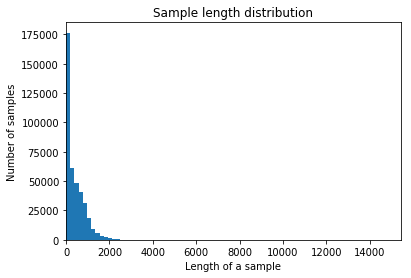

In [13]:
plot_sample_length_distribution(train_preprocessed + val_preprocessed)

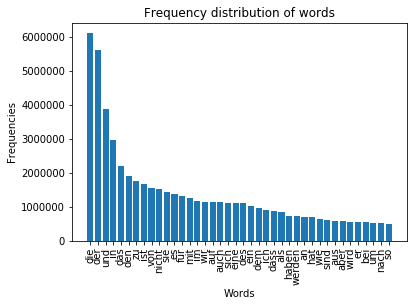

In [14]:
word_frequency = plot_word_frequency_distribution(train_preprocessed + val_preprocessed)

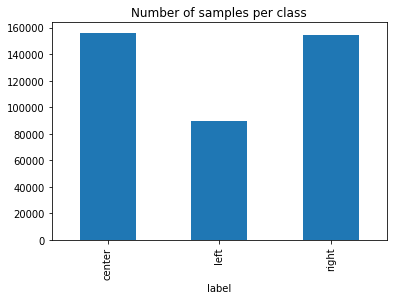

In [15]:
plot_num_samples_per_class(train_labels + val_labels)

## Data Preperation

We tokenize the text as sequences. If you want to use fine-tuned pre-trained embedding download the vocabulary and vectors from [here](https://deepset.ai/german-word-embeddings) and place it in PretrainedEmbedding folder. Then in class *SequenceVectorize()* set *calculate_vocab=False*, in function *get_embedding(...)* set *pretrained_embedding=True*.

In [16]:
sequence_vectorize = SequenceVectorize(train_texts, calculate_vocab=True)
Xtr = sequence_vectorize.vectorize(train_preprocessed)
Xval = sequence_vectorize.vectorize(val_preprocessed)
Ytr, _ = onehot_encoding(train_labels) 
Yval, _ = onehot_encoding(val_labels)

In [17]:
Xte = sequence_vectorize.vectorize(test_texts)
Yte, _ = onehot_encoding(test_labels) 

## Model Building

If you set *pretrained_embedding=True* you can specify if you want to fine-tune the pretrained embedding with setting *finetune_embedding=True*. If you do not want to use a fine-tuned pre-trained embedding then set *pretrained_embedding=False* and specify the embedding dimension *embedding_dim*.

In [18]:
embedding_layer = get_embedding(sequence_vectorize.word_index, 
                                Xtr.shape[1], 
                                pretrained_embedding=False, 
                                finetune_embedding=False, 
                                embedding_dim=300)

model = LongShortTermMemory(embedding_layer, Ytr.shape[1])
opt = tensorflow.keras.optimizers.RMSprop(learning_rate=1e-2)

my_callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', min_lr=1e-6)]

class_weight = compute_class_weight(labels)

### LSTM

In [28]:
lstm = model.lstm(opt, out_dim=256, dropout=0.5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          9000300   
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 9,587,311
Trainable params: 9,587,311
Non-trainable params: 0
_________________________________________________________________


#### Training

In [75]:
history = lstm.fit(Xtr, Ytr, validation_data=(Xval, Yval), epochs=1000, batch_size=1024, 
                    class_weight=class_weight, verbose=1, callbacks=my_callbacks)

Epoch 1/1000
348/348 [==============================] - 135s 389ms/step - loss: 1.2804 - accuracy: 0.4363 - f1: 0.2781 - val_loss: 1.1074 - val_accuracy: 0.3805 - val_f1: 0.1566 - lr: 0.0100
Epoch 2/1000
348/348 [==============================] - 132s 381ms/step - loss: 1.1598 - accuracy: 0.4677 - f1: 0.3235 - val_loss: 0.7773 - val_accuracy: 0.6013 - val_f1: 0.5323 - lr: 0.0100
Epoch 3/1000
348/348 [==============================] - 135s 388ms/step - loss: 0.8144 - accuracy: 0.6375 - f1: 0.6002 - val_loss: 0.6848 - val_accuracy: 0.6348 - val_f1: 0.6057 - lr: 0.0100
Epoch 4/1000
348/348 [==============================] - 131s 377ms/step - loss: 0.7516 - accuracy: 0.6684 - f1: 0.6387 - val_loss: 0.6792 - val_accuracy: 0.6437 - val_f1: 0.6312 - lr: 0.0100
Epoch 5/1000
348/348 [==============================] - 133s 382ms/step - loss: 0.7187 - accuracy: 0.6873 - f1: 0.6617 - val_loss: 0.6747 - val_accuracy: 0.6542 - val_f1: 0.6325 - lr: 0.0100
Epoch 6/1000
348/348 [=======================

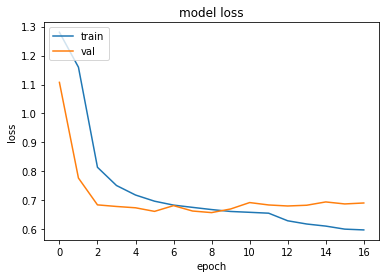

In [76]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Testing

In [66]:
lstm = tensorflow.keras.models.load_model('models/lstm.09-0.66.h5', custom_objects={'f1':f1})

In [67]:
y_pred = lstm.predict(Xte)

In [68]:
acc(Yte, y_pred)

0.6768642447418738

In [69]:
f1(Yte.astype(float), y_pred.astype(float)).numpy()

0.6607589569762246

### Stacked LSTM

In [19]:
my_callbacks.append(tensorflow.keras.callbacks.ModelCheckpoint(filepath='models/stacked_lstm.{epoch:02d}-{val_loss:.2f}.h5'))

In [20]:
stacked_lstm = model.stacked_lstm(opt, hidden_dim=256, num_layers=2, dropout=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          9000300   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 256)          570368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 10,112,623
Trainable params: 10,112,623
Non-trainable params: 0
_________________________________________________________________


#### Training

In [21]:
history = stacked_lstm.fit(Xtr, Ytr, validation_data=(Xval, Yval), epochs=1000, batch_size=1024, 
                           class_weight=class_weight, verbose=1, callbacks=my_callbacks)

Epoch 1/1000
348/348 [==============================] - 176s 505ms/step - loss: 1.3701 - accuracy: 0.3397 - f1: 0.0455 - val_loss: 1.0885 - val_accuracy: 0.3887 - val_f1: 0.0039 - lr: 0.0100
Epoch 2/1000
348/348 [==============================] - 173s 498ms/step - loss: 1.1919 - accuracy: 0.4296 - f1: 0.2080 - val_loss: 0.9265 - val_accuracy: 0.4808 - val_f1: 0.4626 - lr: 0.0100
Epoch 3/1000
348/348 [==============================] - 175s 502ms/step - loss: 0.9363 - accuracy: 0.5803 - f1: 0.5110 - val_loss: 0.7488 - val_accuracy: 0.5836 - val_f1: 0.5509 - lr: 0.0100
Epoch 4/1000
348/348 [==============================] - 176s 504ms/step - loss: 0.8355 - accuracy: 0.6202 - f1: 0.5739 - val_loss: 0.7022 - val_accuracy: 0.6305 - val_f1: 0.6014 - lr: 0.0100
Epoch 5/1000
348/348 [==============================] - 174s 501ms/step - loss: 0.7979 - accuracy: 0.6385 - f1: 0.6016 - val_loss: 0.6941 - val_accuracy: 0.6155 - val_f1: 0.5961 - lr: 0.0100
Epoch 6/1000
348/348 [=======================

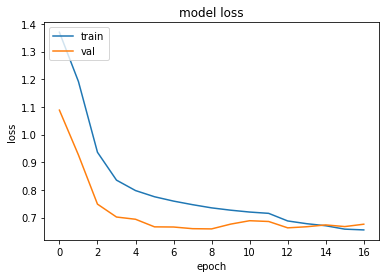

In [24]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Testing

In [25]:
stacked_lstm = tensorflow.keras.models.load_model('models/stacked_lstm.11-0.64.h5', custom_objects={'f1':f1})

In [26]:
y_pred = stacked_lstm.predict(Xte)

In [27]:
acc(Yte, y_pred)

0.6741873804971319

In [28]:
f1(Yte.astype(float), y_pred.astype(float)).numpy()

0.6555553588207572